# AI-Powered URL Phishing Detection System
# Gradient Boosting Classifier for Chatbot

## Steup and Imports

In [1]:
!pip install python-whois dnspython tldextract beautifulsoup4 requests pyOpenSSL tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import os
import re
import requests
import socket
from urllib.parse import urlparse
from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import whois
import dns.resolver
import tldextract
import ssl
import OpenSSL.crypto as crypto
import socket
import concurrent.futures
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration and Logging

### Set up logging

In [4]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [5]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/chatbot/chatbot_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_metadata.json'
TUNED_MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_tuned.pkl'
TUNED_METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_tuned_metadata.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/gradient_boost_training_log.json'

### Create directories if they don't exist

In [ ]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models/gradient_boosting_model', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Load and explore the dataset

### Load dataset

In [6]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

try:
    df = pd.read_csv(RAW_DATA_PATH)
    # Ensure class column is properly named and has numeric values
    if 'label' in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Class distribution: {df['class'].value_counts().to_dict()}")

    log_event("DATA_LOADED", f"Dataset loaded with shape {df.shape}")
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-04-28T16:28:07.445590] DATA_LOADING: Loading dataset
Class values in dataset: [1 0]
[2025-04-28T16:28:09.392996] DATA_LOADED: Dataset loaded with shape (4000, 2)
[2025-04-28T16:28:09.393318] TIMING: Data loading completed in 1.95 seconds


### Display basic information

In [7]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 4000
Features: 2

Data Types:
URL      object
class     int64
dtype: object

Class Distribution:
class
1    2000
0    2000
Name: count, dtype: int64

First 5 rows:
                                            URL  class
0  https://start-support-tizer.gitbook.io/en-us      1
1       https://iieudsjwasndjfkdjdd.weebly.com/      1
2           https://0x-turbos.pages.dev/wallets      1
3                   https://shbox.top/yecunoeu/      1
4            https://sparkflrdrops.xyz/clm.html      1


## 2. Feature Extraction Functions

In [8]:
log_event("FEATURE_EXTRACTION_FUNCTIONS", "Extracting functions for chatbot deep analysis")
start_time = time.time()

[2025-04-28T16:28:14.767550] FEATURE_EXTRACTION_FUNCTIONS: Extracting functions for chatbot deep analysis


Extract comprehensive features for deep analysis in the chatbot based on the specified list:
  - UsingIP
  - LongURL
  - ShortURL
  - Symbol@
  - Redirecting//
  - PrefixSuffix-
  - SubDomains
  - HTTPS
  - DomainRegLen
  - Favicon
  - NonStdPort
  - HTTPSDomainURL
  - RequestURL
  - AnchorURL
  - LinksInScriptTags
  - ServerFormHandler
  - InfoEmail
  - AbnormalURL
  - WebsiteForwarding
  - StatusBarCust
  - DisableRightClick
  - UsingPopupWindow
  - IframeRedirection
  - AgeofDomain
  - DNSRecording
  - WebsiteTraffic
  - PageRank
  - GoogleIndex
  - LinksPointingToPage
  - StatsReport

### URL Parsing

In [9]:
def get_domain(url):
    """Extract domain from URL"""
    try:
        extracted = tldextract.extract(url)
        domain = f"{extracted.domain}.{extracted.suffix}"
        if extracted.subdomain:
            full_domain = f"{extracted.subdomain}.{domain}"
        else:
            full_domain = domain
        return domain, full_domain
    except:
        return None, None

### WHOIS Information

In [10]:
def get_domain_info(domain):
    """Get domain registration info using WHOIS"""
    try:
        w = whois.whois(domain)

        # Get creation date
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]

        # Get expiration date
        expiration_date = w.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]

        # Calculate age in days
        if creation_date:
            domain_age = (datetime.now() - creation_date).days
        else:
            domain_age = -1

        # Calculate registration length in days
        if creation_date and expiration_date:
            reg_len = (expiration_date - creation_date).days
        else:
            reg_len = -1

        return {
            'domain_age': domain_age,
            'registration_length': reg_len
        }
    except Exception as e:
        return {
            'domain_age': -1,
            'registration_length': -1
        }

### DNS Records

In [12]:
def get_dns_records(domain):
    """Check if domain has proper DNS records"""
    records = {
        'has_a': False,
        'has_mx': False,
        'has_ns': False,
        'has_txt': False,
        'total_records': 0
    }

    try:
        # A record
        try:
            answers = dns.resolver.resolve(domain, 'A')
            records['has_a'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # MX record
        try:
            answers = dns.resolver.resolve(domain, 'MX')
            records['has_mx'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # NS record
        try:
            answers = dns.resolver.resolve(domain, 'NS')
            records['has_ns'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # TXT record
        try:
            answers = dns.resolver.resolve(domain, 'TXT')
            records['has_txt'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        return records
    except Exception as e:
        return records

### HTML Content Analysis

In [13]:
def analyze_html_content(url):
    """Analyze HTML content for suspicious patterns"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }
        response = requests.get(url, headers=headers, timeout=5)

        if response.status_code != 200:
            return {
                'has_favicon': False,
                'external_favicon': False,
                'form_action_external': False,
                'has_password_field': False,
                'has_hidden_element': False,
                'external_scripts': 0,
                'iframe_count': 0,
                'onclick_count': 0,
                'external_links': 0,
                'internal_links': 0,
                'null_links': 0,
                'has_right_click_disabled': False,
                'has_popup': False,
                'status_bar_customized': False
            }

        soup = BeautifulSoup(response.text, 'html.parser')
        domain, full_domain = get_domain(url)

        # Check favicon
        favicon = soup.find('link', rel=lambda r: r and 'icon' in r.lower())
        has_favicon = favicon is not None
        external_favicon = False
        if has_favicon and favicon.get('href'):
            favicon_url = favicon['href']
            if not favicon_url.startswith('data:'):
                if favicon_url.startswith('http'):
                    favicon_domain = get_domain(favicon_url)[0]
                    external_favicon = favicon_domain != domain

        # Check forms
        forms = soup.find_all('form')
        form_action_external = False
        for form in forms:
            action = form.get('action', '')
            if action and action.startswith('http'):
                action_domain = get_domain(action)[0]
                if action_domain != domain:
                    form_action_external = True
                    break

        # Check for password fields
        has_password_field = len(soup.find_all('input', type='password')) > 0

        # Check for hidden elements
        has_hidden_element = len(soup.find_all('input', type='hidden')) > 0

        # Count scripts from external domains
        scripts = soup.find_all('script', src=True)
        external_scripts = 0
        for script in scripts:
            if script['src'].startswith('http'):
                script_domain = get_domain(script['src'])[0]
                if script_domain != domain:
                    external_scripts += 1

        # Count iframes
        iframe_count = len(soup.find_all('iframe'))

        # Count onclick events
        elements_with_onclick = soup.find_all(lambda tag: tag.has_attr('onclick'))
        onclick_count = len(elements_with_onclick)

        # Analyze links
        links = soup.find_all('a', href=True)
        external_links = 0
        internal_links = 0
        null_links = 0

        for link in links:
            href = link['href'].lower()
            if href == '#' or href == 'javascript:void(0)':
                null_links += 1
            elif href.startswith('http'):
                link_domain = get_domain(href)[0]
                if link_domain != domain:
                    external_links += 1
                else:
                    internal_links += 1
            else:
                internal_links += 1

        # Check for right-click disabling
        has_right_click_disabled = 'oncontextmenu="return false"' in response.text or 'event.button==2' in response.text

        # Check for popups
        has_popup = 'window.open(' in response.text

        # Check for status bar customization
        status_bar_customized = 'window.status' in response.text

        return {
            'has_favicon': has_favicon,
            'external_favicon': external_favicon,
            'form_action_external': form_action_external,
            'has_password_field': has_password_field,
            'has_hidden_element': has_hidden_element,
            'external_scripts': external_scripts,
            'iframe_count': iframe_count,
            'onclick_count': onclick_count,
            'external_links': external_links,
            'internal_links': internal_links,
            'null_links': null_links,
            'has_right_click_disabled': has_right_click_disabled,
            'has_popup': has_popup,
            'status_bar_customized': status_bar_customized
        }
    except Exception as e:
        return {
            'has_favicon': False,
            'external_favicon': False,
            'form_action_external': False,
            'has_password_field': False,
            'has_hidden_element': False,
            'external_scripts': 0,
            'iframe_count': 0,
            'onclick_count': 0,
            'external_links': 0,
            'internal_links': 0,
            'null_links': 0,
            'has_right_click_disabled': False,
            'has_popup': False,
            'status_bar_customized': False
        }

### Parallel feature extraction

In [14]:
def extract_url_features(url):
    """Extract all features for a single URL"""
    # Basic URL features
    features = {}

    # Check if URL uses IP address
    features['UsingIP'] = 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)) else 0

    # URL length
    features['LongURL'] = 1 if len(url) > 75 else 0

    # Check for URL shortening services
    url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly', 'tiny.cc', 'shorte.st']
    features['ShortURL'] = 1 if any(shortener in url for shortener in url_shorteners) else 0

    # Check for @ symbol
    features['Symbol@'] = 1 if '@' in url else 0

    # Check for multiple forward slashes
    features['Redirecting//'] = 1 if url.count('//') > 1 else 0

    # Extract domain information
    domain, full_domain = get_domain(url)

    if not domain:
        # If domain extraction failed, return basic features with default values
        return {**features,
                'PrefixSuffix-': 0,
                'SubDomains': 0,
                'HTTPS': 0,
                'DomainRegLen': 0,
                'Favicon': 0,
                'NonStdPort': 0,
                'HTTPSDomainURL': 0,
                'RequestURL': 0,
                'AnchorURL': 0,
                'LinksInScriptTags': 0,
                'ServerFormHandler': 0,
                'InfoEmail': 0,
                'AbnormalURL': 0,
                'WebsiteForwarding': 0,
                'StatusBarCust': 0,
                'DisableRightClick': 0,
                'UsingPopupWindow': 0,
                'IframeRedirection': 0,
                'AgeofDomain': 0,
                'DNSRecording': 0,
                'WebsiteTraffic': 0,
                'PageRank': 0,
                'GoogleIndex': 0,
                'LinksPointingToPage': 0,
                'StatsReport': 0}

    # Check for hyphen in domain
    features['PrefixSuffix-'] = 1 if '-' in domain else 0

    # Count subdomains
    extracted = tldextract.extract(url)
    features['SubDomains'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0

    # Check if URL uses HTTP
    features['uses_http'] = 0 if url.startswith('https') else 1

    # Get WHOIS information
    whois_info = get_domain_info(domain)
    features['DomainRegLen'] = 1 if whois_info['registration_length'] > 365 else 0
    features['AgeofDomain'] = 1 if whois_info['domain_age'] > 180 else 0

    # Check for non-standard port
    parsed_url = urlparse(url)
    port = parsed_url.port
    features['NonStdPort'] = 1 if port and port not in [80, 443] else 0

    # Check if 'https' appears in domain part
    features['HTTPSDomainURL'] = 1 if 'https' in domain or 'http' in domain else 0

    # Check for suspicious terms in URL
    suspicious_terms = ['login', 'signin', 'verify', 'account', 'security', 'update', 'confirm', 'payment']
    features['AbnormalURL'] = 1 if any(term in url.lower() for term in suspicious_terms) else 0

    # Check for email-related terms
    features['InfoEmail'] = 1 if any(term in url.lower() for term in ['mail', 'email', 'contact']) else 0

    # Get DNS Records
    dns_info = get_dns_records(domain)
    features['DNSRecording'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Website popularity estimation (based on DNS records as a proxy)
    features['WebsiteTraffic'] = 1 if dns_info['total_records'] > 3 else 0
    features['PageRank'] = 1 if dns_info['has_a'] and dns_info['has_mx'] and dns_info['has_ns'] else 0
    features['GoogleIndex'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Links pointing to the page (estimate based on domain age)
    features['LinksPointingToPage'] = 1 if whois_info['domain_age'] > 365 else 0

    # Stats report availability (estimate based on domain age and DNS)
    features['StatsReport'] = 1 if whois_info['domain_age'] > 180 and dns_info['total_records'] > 3 else 0

    # Try to get HTML content analysis
    # Only attempt for URLs that use HTTP/HTTPS
    if url.startswith('http'):
        try:
            html_info = analyze_html_content(url)

            # Favicon from different domain
            features['Favicon'] = 1 if html_info['external_favicon'] else 0

            # External request URLs
            features['RequestURL'] = 1 if html_info['external_scripts'] > 0 else 0

            # External anchor URLs
            features['AnchorURL'] = 1 if html_info['external_links'] > html_info['internal_links'] else 0

            # Links in script tags
            features['LinksInScriptTags'] = 1 if html_info['external_scripts'] > 2 else 0

            # Server form handler
            features['ServerFormHandler'] = 1 if html_info['form_action_external'] else 0

            # Website forwarding
            features['WebsiteForwarding'] = 1 if html_info['null_links'] > 3 else 0

            # Status bar customization
            features['StatusBarCust'] = 1 if html_info['status_bar_customized'] else 0

            # Right-click disabled
            features['DisableRightClick'] = 1 if html_info['has_right_click_disabled'] else 0

            # Popup windows
            features['UsingPopupWindow'] = 1 if html_info['has_popup'] else 0

            # Iframe redirection
            features['IframeRedirection'] = 1 if html_info['iframe_count'] > 0 else 0

        except Exception as e:
            # Default values for HTML features if analysis fails
            features['Favicon'] = 0
            features['RequestURL'] = 0
            features['AnchorURL'] = 0
            features['LinksInScriptTags'] = 0
            features['ServerFormHandler'] = 0
            features['WebsiteForwarding'] = 0
            features['StatusBarCust'] = 0
            features['DisableRightClick'] = 0
            features['UsingPopupWindow'] = 0
            features['IframeRedirection'] = 0
    else:
        # Default values for HTML features for non-HTTP URLs
        features['Favicon'] = 0
        features['RequestURL'] = 0
        features['AnchorURL'] = 0
        features['LinksInScriptTags'] = 0
        features['ServerFormHandler'] = 0
        features['WebsiteForwarding'] = 0
        features['StatusBarCust'] = 0
        features['DisableRightClick'] = 0
        features['UsingPopupWindow'] = 0
        features['IframeRedirection'] = 0

    return features

In [ ]:
log_event("TIMING", "Feature extraction functions defined")

## 3. Feature Extraction with Parallelization

In [15]:
log_event("FEATURE_EXTRACTION", "Starting comprehensive feature extraction for chatbot model")

[2025-04-28T16:28:52.244648] FEATURE_EXTRACTION: Starting comprehensive feature extraction for chatbot model


### Empty features DataFrame

In [17]:
empty_features = {
    'UsingIP': 0, 'LongURL': 0, 'ShortURL': 0, 'Symbol@': 0,
    'Redirecting//': 0, 'PrefixSuffix-': 0, 'SubDomains': 0,
    'HTTPS': 0, 'DomainRegLen': 0, 'Favicon': 0, 'NonStdPort': 0,
    'HTTPSDomainURL': 0, 'RequestURL': 0, 'AnchorURL': 0,
    'LinksInScriptTags': 0, 'ServerFormHandler': 0, 'InfoEmail': 0,
    'AbnormalURL': 0, 'WebsiteForwarding': 0, 'StatusBarCust': 0,
    'DisableRightClick': 0, 'UsingPopupWindow': 0, 'IframeRedirection': 0,
    'AgeofDomain': 0, 'DNSRecording': 0, 'WebsiteTraffic': 0,
    'PageRank': 0, 'GoogleIndex': 0, 'LinksPointingToPage': 0,
    'StatsReport': 0
}

In [18]:
batch_size = 50
url_list = df['URL'].tolist()
url_to_class = dict(zip(df['URL'], df['class']))

# Initialize containers
all_results = []
all_classes = []

In [19]:
log_event("FEATURE_EXTRACTION", f"Processing {len(url_list)} URLs in batches of {batch_size}")

[2025-04-28T16:28:59.878134] FEATURE_EXTRACTION: Processing 4000 URLs in batches of 50


In [20]:
with ThreadPoolExecutor(max_workers=16) as executor:
    for i in tqdm(range(0, len(url_list), batch_size)):
        batch = url_list[i:i+batch_size]

        # Keep track of the correct classes for this batch
        batch_classes = [url_to_class[url] for url in batch]

        future_to_url = {executor.submit(extract_url_features, url): url for url in batch}

        batch_results = []
        batch_processed_classes = []

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                features = future.result()
                batch_results.append(features)
                batch_processed_classes.append(url_to_class[url])
            except Exception as e:
                log_event("ERROR", f"Failed to extract features for URL: {url[:50]}... - {str(e)}")
                batch_results.append(empty_features.copy())
                batch_processed_classes.append(url_to_class[url])

        all_results.extend(batch_results)
        all_classes.extend(batch_processed_classes)

# Create DataFrame from results
features_df = pd.DataFrame(all_results)
features_df['is_phishing'] = all_classes

# Handle any potential numeric issues
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)

# Save processed features
features_df.to_csv(PROCESSED_DATA_PATH, index=False)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-04-28 16:29:04,072 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-28 16:29:06,323 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-28 16:29:27,146 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-28 16:29:27,149 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-28 16:29:27,150 

Saved all results after processing complete!


In [ ]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": features_df.shape[1] - 1})

## 4. Feature Analysis

In [27]:
print("\nExtracted Features Summary:")
print(features_df.describe())



Extracted Features Summary:
           UsingIP      LongURL    ShortURL     Symbol@  Redirecting//  \
count  4000.000000  4000.000000  4000.00000  4000.00000    4000.000000   
mean      0.003000     0.115250     0.08225     0.00375       0.000500   
std       0.054697     0.319363     0.27478     0.06113       0.022358   
min       0.000000     0.000000     0.00000     0.00000       0.000000   
25%       0.000000     0.000000     0.00000     0.00000       0.000000   
50%       0.000000     0.000000     0.00000     0.00000       0.000000   
75%       0.000000     0.000000     0.00000     0.00000       0.000000   
max       1.000000     1.000000     1.00000     1.00000       1.000000   

       PrefixSuffix-   SubDomains        HTTPS  DomainRegLen  AgeofDomain  \
count    4000.000000  4000.000000  4000.000000   4000.000000  4000.000000   
mean        0.472250     0.509000     0.531250      0.419250     0.430000   
std         0.499292     0.591191     0.499085      0.493498     0.495138

### Dsiplay correlation with target

In [ ]:
correlations = features_df.corr()['is_phishing'].sort_values(ascending=False)
print("\nTop 10 Features by Correlation with Target:")
print(correlations.head(10))
print("\nBottom 10 Features by Correlation with Target:")
print(correlations.tail(10))

### Create correlation heatmap

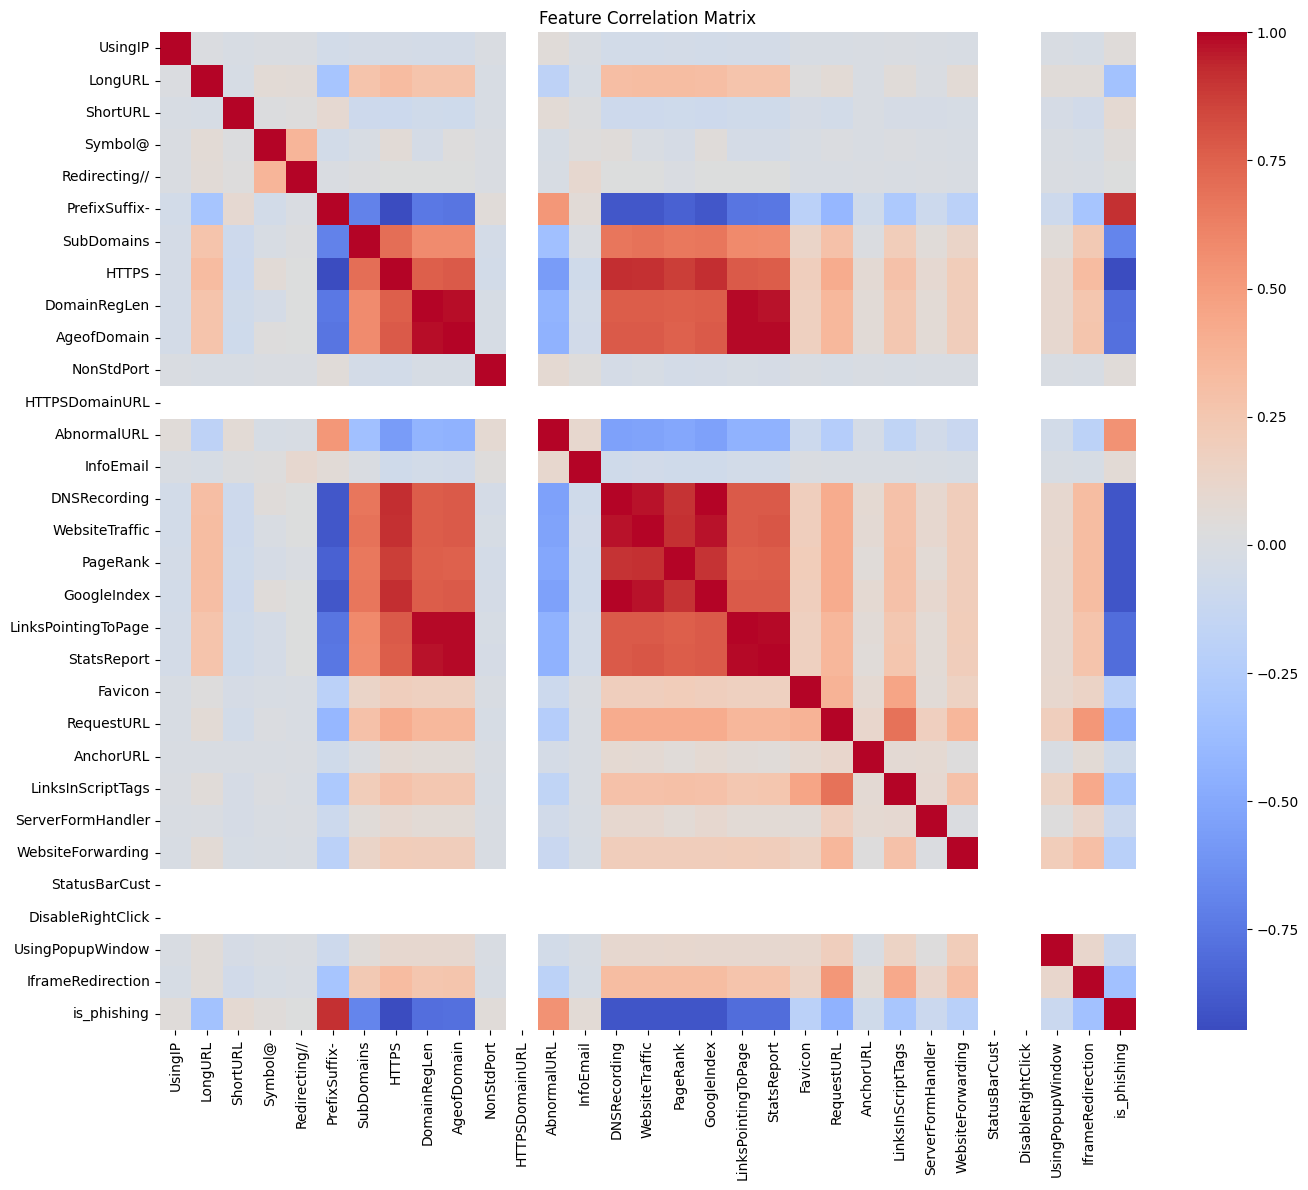

In [28]:
plt.figure(figsize=(14, 12))
sns.heatmap(features_df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Model Training

In [29]:
log_event("MODEL_TRAINING", "Starting model training with Gradient Boosting")
start_time = time.time()

[2025-04-28T17:00:10.754875] MODEL_TRAINING: Starting model training with Gradient Boosting


### Prepare features and target

In [30]:
X = features_df.drop('is_phishing', axis=1)
y = features_df['is_phishing']

### Split data (80% train, 20% test)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [36]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-04-28T17:00:50.214888] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Gradient Boosting model

In [40]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=200,
    min_samples_leaf=50,
    subsample=0.8,
    random_state=42
)

In [41]:
gb_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=50,
                           min_samples_split=200, random_state=42,
                           subsample=0.8)

In [42]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-04-28T17:01:21.341472] TIMING: Model training completed in 70.59 seconds


## 6. Model Evaluation

In [43]:
log_event("MODEL_EVALUATION", "Evaluating Gradient Boosting model")
start_time = time.time()

[2025-04-28T17:01:24.813719] MODEL_EVALUATION: Evaluating Gradient Boosting model


### Make predictions

In [44]:
y_pred = gb_model.predict(X_test_scaled)
y_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### ROC curve and AUC

In [46]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [47]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc)
})

[2025-04-28T17:01:31.652263] EVALUATION_METRICS: Model performance metrics


In [48]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9862
Precision: 0.9850
Recall: 0.9875
F1 Score: 0.9863
AUC: 0.9990


### Plot confusion matrix

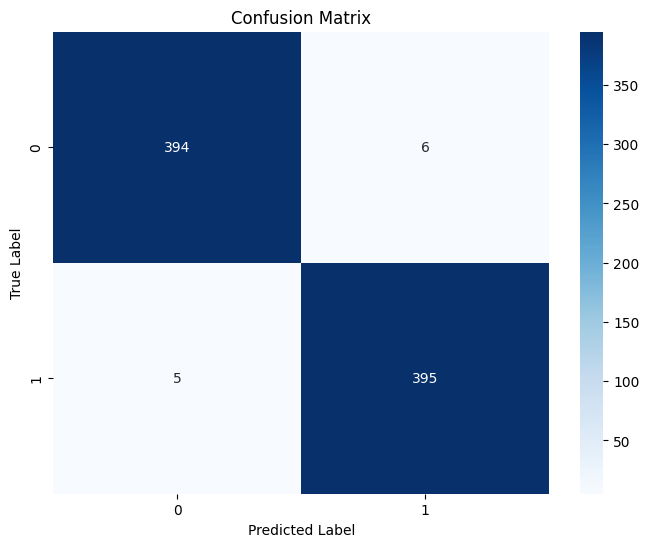

In [49]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

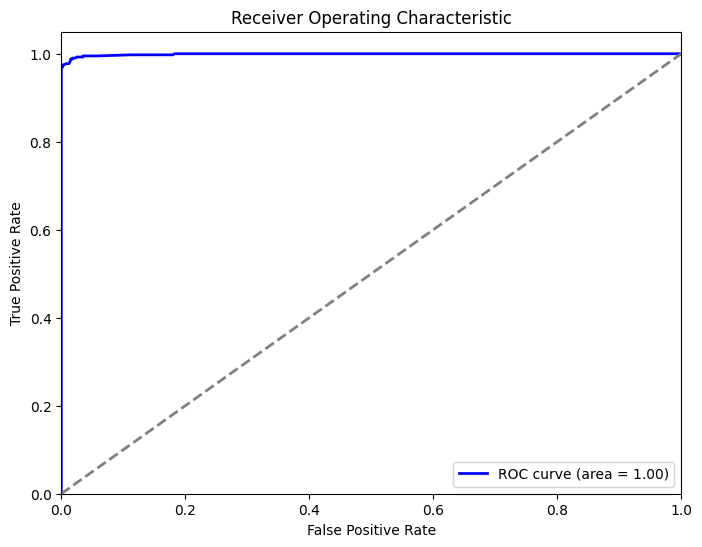

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [51]:
feature_importances = pd.DataFrame(
    gb_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

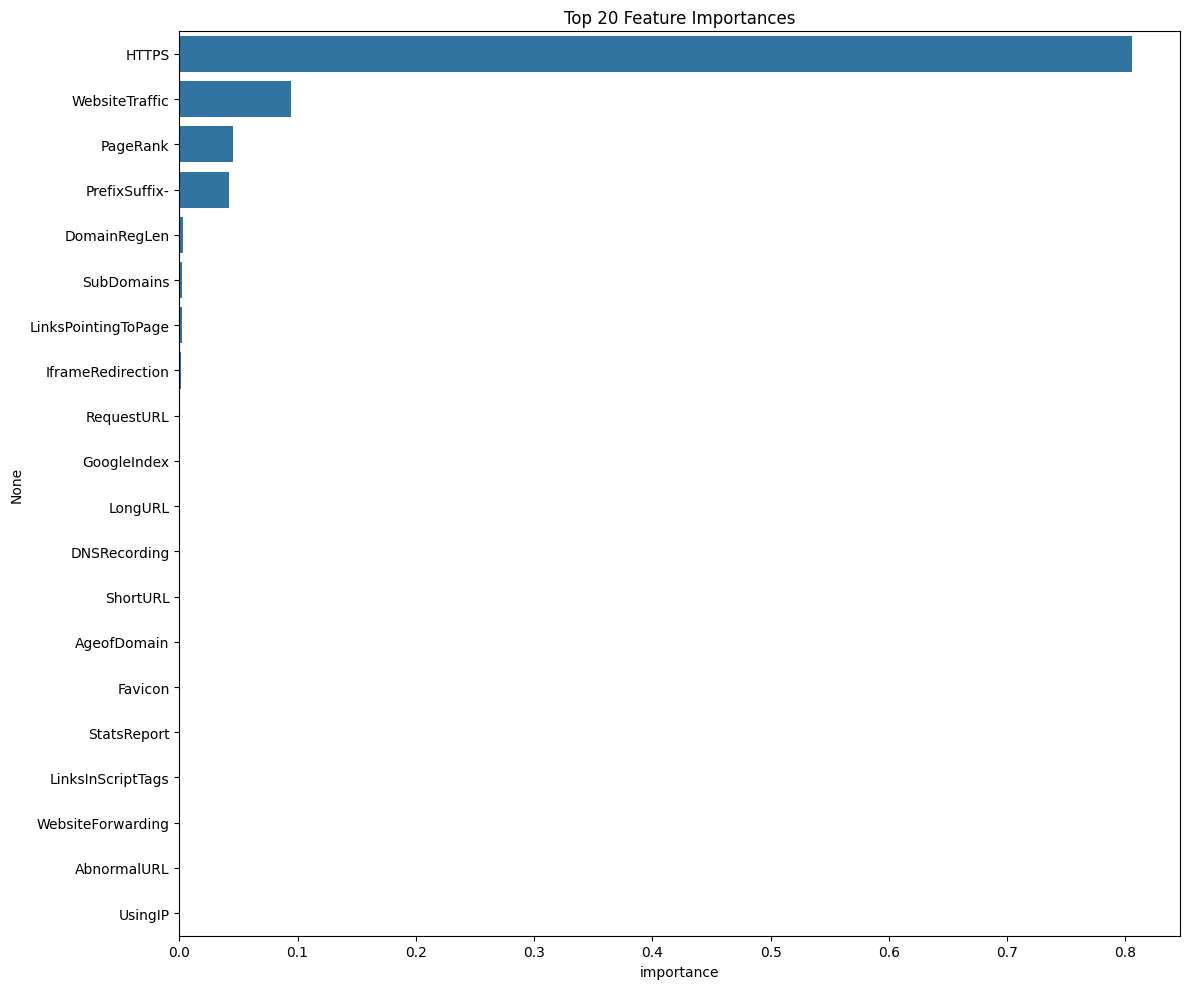

In [52]:
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances['importance'].head(15), y=feature_importances.index[:15])
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [53]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-04-28T17:01:49.854447] TIMING: Model evaluation completed in 25.04 seconds


## 7. Hyperparameter Tuning

In [60]:
log_event("HYPERPARAMETER_TUNING", "Starting hyperparameter tuning")
start_time = time.time()

[2025-04-28T17:02:03.286238] HYPERPARAMETER_TUNING: Starting hyperparameter tuning


### Focused parameter grid based on initial model performance

In [61]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [100, 200, 300],
    'min_samples_leaf': [30, 50, 70],
    'subsample': [0.7, 0.8, 0.9]
}

### Subset of data for faster tuning

In [62]:
X_tune = X_train_scaled[:min(1000, X_train_scaled.shape[0])]
y_tune = y_train[:min(1000, y_train.shape[0])]

### Set up cross-validation grid search

In [63]:
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

### Run grid search

In [64]:
grid_search.fit(X_tune, y_tune)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [30, 50, 70],
                         'min_samples_split': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1')

In [65]:
tuning_time = time.time() - start_time
log_event("TIMING", f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")

[2025-04-28T17:05:17.081574] TIMING: Hyperparameter tuning completed in 193.80 seconds


### Log the best parameters

In [66]:
log_event("HYPERPARAMETER_TUNING", "Best parameters found", {
    "parameters": grid_search.best_params_,
    "f1_score": float(grid_search.best_score_)
})

[2025-04-28T17:05:21.007370] HYPERPARAMETER_TUNING: Best parameters found


In [67]:
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")


Best Parameters:
learning_rate: 0.2
max_depth: 5
min_samples_leaf: 30
min_samples_split: 300
subsample: 0.8
Best F1 Score: 0.9839


### Final model with the best parameters (on full training data)

In [68]:
final_model = GradientBoostingClassifier(
    n_estimators=100,
    **grid_search.best_params_,
    random_state=42
)

In [69]:
final_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=30,
                           min_samples_split=300, random_state=42,
                           subsample=0.8)

### Evaluate final model

In [70]:
final_pred = final_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)

In [71]:
log_event("FINAL_MODEL_EVALUATION", "Final model performance after tuning", {
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1)
})

[2025-04-28T17:05:39.862276] FINAL_MODEL_EVALUATION: Final model performance after tuning


In [72]:
print("\nFinal Model Performance After Tuning:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")


Final Model Performance After Tuning:
Accuracy: 0.9862
Precision: 0.9875
Recall: 0.9850
F1 Score: 0.9862


## 8. Testing with Real-World URLs

In [ ]:
log_event("MODEL_TESTING", "Testing final model with real-world URLs")

In [ ]:
def extract_features_for_test(url):
    """Extract features for a single test URL"""
    return extract_url_features(url)

In [ ]:
def test_url(url, model, scaler):
    """Test a single URL with the trained model"""
    features = extract_features_for_test(url)
    features_df = pd.DataFrame([features])
    features_scaled = scaler.transform(features_df)
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0, 1]  # Probability of being phishing
    return prediction, probability, features

### Test legitimate sites

In [ ]:
legitimate_urls = [
    "https://www.google.com",
    "https://www.amazon.com",
    "https://www.github.com",
    "https://www.nytimes.com",
    "https://www.microsoft.com"
]

In [ ]:
print("\n==== Testing Known Legitimate URLs ====")
for url in legitimate_urls:
    try:
        prediction, probability, features = test_url(url, final_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 1 else "✅ CORRECT"
        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: HTTPS={features['HTTPS']}, SubDomains={features['SubDomains']}, DomainRegLen={features['DomainRegLen']}")
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")

### Test known phishing patterns

In [ ]:
phishing_patterns = [
    "http://secure-paypal.com.verification.loginauth.net/signin",  # Suspicious domain
    "https://accounts-google.com.verify.suspicious-domain.com/login",  # Subdomain abuse
    "https://www.bankofamerica.com.secure.id123.info/login.php",  # Domain spoofing
    "http://paypal-secure.verification.loginauth.com/signin",  # Brand + suspicious words
    "https://www.amazonsecure.phishing-attempt.net/login"  # Brand + suspicious domain
]

In [ ]:
print("\n==== Testing Phishing URL Patterns ====")
for url in phishing_patterns:
    try:
        prediction, probability, features = test_url(url, final_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 0 else "✅ CORRECT"
        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: HTTPS={features['HTTPS']}, SubDomains={features['SubDomains']}, AbnormalURL={features['AbnormalURL']}")
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")

## 9. Save Model and Artifacts

In [ ]:
log_event("MODEL_SAVING", "Saving model and artifacts")
start_time = time.time()

### Save the models

In [ ]:
joblib.dump(gb_model, MODEL_OUTPUT_PATH)
joblib.dump(final_model, TUNED_MODEL_OUTPUT_PATH)
joblib.dump(scaler, SCALER_OUTPUT_PATH)

### Save feature names for inference

In [ ]:
with open(f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_features.json', 'w') as f:
    json.dump(list(X.columns), f)

### Save model parameters and metadata

In [ ]:
model_info = {
    "name": "gradient_boost_v1",
    "type": "gradient_boost",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": gb_model.n_estimators,
        "learning_rate": gb_model.learning_rate,
        "max_depth": gb_model.max_depth,
        "min_samples_split": gb_model.min_samples_split,
        "min_samples_leaf": gb_model.min_samples_leaf,
        "subsample": gb_model.subsample
    },
    "feature_importances": feature_importances.to_dict(),
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0],
    "features_implemented": list(X.columns)
}

In [ ]:
with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(model_info, f, indent=2)

### Save model parameters and metadata for the tuned model

In [ ]:
tuned_model_info = {
    "name": "gradient_boost_tuned_v1",
    "type": "gradient_boost",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1),
    "parameters": {
        "n_estimators": final_model.n_estimators,
        **grid_search.best_params_
    },
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0]
}

In [ ]:
with open(TUNED_METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(tuned_model_info, f, indent=2)

### Save all logs to file

In [73]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-04-28T17:05:47.445973] TIMING: Model saving completed in 224.16 seconds


In [74]:
def save_logs_with_append(log_data, log_file_path):
    try:
        with open(log_file_path, 'r') as f:
            try:
                existing_logs = json.load(f)
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                existing_logs = []
    except FileNotFoundError:
        existing_logs = []

    combined_logs = existing_logs + log_data

    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

In [75]:
save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 20 new log entries to /content/drive/MyDrive/PUSL3190/logs/gradient_boost_training_log.json


In [79]:
print("\n===== TRAINING COMPLETE =====")
print(f"Initial model accuracy: {accuracy:.4f}")
print(f"Final tuned model accuracy: {final_accuracy:.4f}")
print(f"Models saved to {MODEL_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Initial model accuracy: 0.9862
Final tuned model accuracy: 0.9862
Models saved to /content/drive/MyDrive/PUSL3190/models/gradient_boosting_model/gradient_boost_model.pkl
Logs saved to /content/drive/MyDrive/PUSL3190/logs/gradient_boost_training_log.json
